In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm.auto import tqdm

import sys
sys.path.append("../")
import json

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-07-31 12:21:12 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-07-31 12:21:12 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-07-31 12:21:12 __main__ INFO     transformers.__version__='4.42.4'


In [3]:
from dataclasses_json import DataClassJsonMixin
from dataclasses import dataclass, field, fields
from typing import Optional
import random
from src.dataset import BridgeSample, BridgeRelation, BridgeDataset
from src.dataset import load_bridge_relation, load_bridge_relations, load_bridge_dataset        

In [4]:
cached_known_dir = os.path.join(
    env_utils.DEFAULT_DATA_DIR,
    "bridge_cached"
)

file_name = os.listdir(cached_known_dir)[0]

with open (os.path.join(cached_known_dir, file_name), "r") as f:
    json_data = json.load(f)

dataset = BridgeDataset.from_dict(json_data)

2024-07-31 12:21:14 src.dataset INFO     initialized bridge relation superpower_characters with 26 examples
2024-07-31 12:21:14 src.dataset INFO     initialized bridge relation sport_players with 22 examples


2024-07-31 12:21:14 src.dataset INFO     initialized bridge relation movie_actor with 51 examples
2024-07-31 12:21:14 src.dataset INFO     initialized bridge relation architect_building with 20 examples
2024-07-31 12:21:14 src.dataset INFO     initialized bridge dataset with 4 relations and 95 examples


In [5]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

model_key = "meta-llama/Meta-Llama-3-8B-Instruct"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-07-31 12:21:16 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

2024-07-31 12:21:21 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Meta-Llama-3-8B-Instruct> | size: 15316.516 MB | dtype: torch.float16 | device: cuda:0


In [66]:
from src.models import prepare_input
from src.functional import predict_next_token, predict_bridge_entity

mt.reset_forward()

s_idx = 38
question, answer = dataset[s_idx]

# question = "Eiffel Tower is located in the city of"

print(question)
# predict_bridge_entity(mt, question)

Given two entities, find a common link between them.
#
What is a common link between Wolverine and Deadpool?
A: healing factor - an attribute that both characters Wolverine and Deadpool possess.
#
What is a common link between Kelly Slater and Andy Irons?
A: surfing - a sport where both Kelly Slater and Andy Irons are known for.
#
What is a common link between Colin Firth and King George VI?
A: The King's Speech - a movie where Colin Firth played the role of King George VI.
#
What is a common link between Fallingwater and Guggenheim Museum?
A: Frank Lloyd Wright - who was the architect of both buildings Fallingwater and Guggenheim Museum.
#
What is a common link between Michael Vaughan and Sourav Ganguly?
A:


In [67]:
inputs = prepare_input(
    prompts = question,
    tokenizer=mt,
    add_bos_token=False
)
base_prediction = predict_next_token(mt, inputs, k=1)[0][0]
base_prediction

PredictedToken(token=' captain', prob=0.14219197630882263, token_id=tensor(24862, device='cuda:0'))

In [69]:
import types
import baukit
from src.hooking.llama_attention import LlamaAttentionPatcher, AttentionEdge
from tqdm.auto import tqdm

head_ablation_results = torch.zeros(mt.n_layer, mt.config.num_attention_heads) - 1

ablation_spec = []
for q_idx in range(1, inputs["input_ids"].shape[1]):
    ablation_spec.extend(
        [AttentionEdge(q_idx, k_idx) for k_idx in range(1, q_idx + 1)]
    )

for layer in tqdm(range(mt.n_layer)):
    for head in range(mt.config.num_attention_heads):
        mt.reset_forward()

        module_name = mt.attn_module_name_format.format(layer)
        attn_module = baukit.get_module(
            mt._model,
            module_name
        )
        # cache_attn_matrices = {}
        # cache_attn_contributions = {}

        attn_module.forward = types.MethodType(
            LlamaAttentionPatcher(
                # block_name=module_name,
                # save_attn_for=[head],
                # attn_matrices=cache_attn_matrices,
                # attn_contributions=cache_attn_contributions,
                cut_attn_edges={
                    head: ablation_spec
                }
            ),
            attn_module
        )

        output = mt._model(**inputs)
        logits = output.logits[:, -1, :].squeeze()
        head_ablation_results[layer, head] = logits.softmax(dim=-1)[base_prediction.token_id].item()

100%|██████████| 32/32 [04:44<00:00,  8.91s/it]


In [71]:
head_ablation_effects = (base_prediction.prob - head_ablation_results) / base_prediction.prob
head_ablation_effects.shape

torch.Size([32, 32])

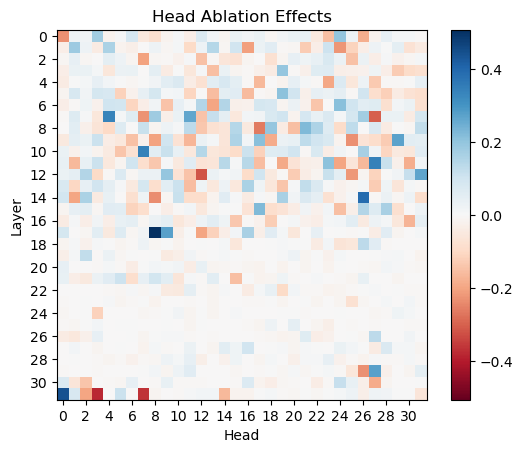

In [72]:
from src.plotting import matrix_heatmap

matrix_heatmap(
    matrix = head_ablation_effects,
    x_label="Head",
    y_label="Layer",
    tick_gap=2,
    title="Head Ablation Effects",
)

In [91]:
@dataclass(frozen=True)
class HeadAblationEffect(DataClassJsonMixin):
    layer: int
    head: int
    effect: float

topk = head_ablation_effects.reshape(head_ablation_effects.shape[0] * head_ablation_effects.shape[1]).topk(1)
indices = [
    (
        i.item() // head_ablation_effects.shape[1],
        i.item() % head_ablation_effects.shape[1],
    ) for i in topk.indices
]

top_effects = [
    HeadAblationEffect(
        layer=i,
        head=j,
        effect=head_ablation_effects[i, j].item()
    ) for i, j in indices
]

top_effects

[HeadAblationEffect(layer=17, head=8, effect=0.506324827671051)]

In [92]:
mt.reset_forward()

for effect in top_effects:
    module_name = mt.attn_module_name_format.format(effect.layer)
    attn_module = baukit.get_module(
        mt._model,
        module_name
    )
    attn_module.forward = types.MethodType(
        LlamaAttentionPatcher(
            cut_attn_edges={
                effect.head: ablation_spec
            }
        ),
        attn_module
    )

output = mt._model(**inputs)
logits = output.logits[:, -1, :].squeeze()
print(logits.softmax(dim=-1)[base_prediction.token_id].item())

from src.functional import interpret_logits
interpret_logits(
    tokenizer = mt, logits = logits,
    k = 5, get_proba = True
)

0.07019665092229843


[(' Cricket', 0.184),
 (' Captain', 0.155),
 (' England', 0.126),
 (' Test', 0.108),
 (' captain', 0.07)]

In [94]:
mt.reset_forward()

layer = top_effects[0].layer
head = top_effects[0].head

module_name = mt.attn_module_name_format.format(layer)
attn_module = baukit.get_module(
    mt._model,
    module_name
)
cache_attn_matrices = {}
cache_attn_contributions = {}

attn_module.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=module_name,
        save_attn_for=[head],
        attn_matrices=cache_attn_matrices,
        attn_contributions=cache_attn_contributions,
        # cut_attn_edges={
        #     head: ablation_spec
        # }
    ),
    attn_module
)

output = mt._model(**inputs)
logits = output.logits[:, -1, :].squeeze()

interpret_logits(
    tokenizer = mt, logits = logits,
    k = 5, get_proba = True
)

2024-07-31 13:52:17 src.hooking.llama_attention WARNING  torch.allclose(attn_output, __attn_output, atol=1e-3)=True | attn_output.norm().item()=28.96875, __attn_output.norm().item()=28.96875


[(' captain', 0.143),
 (' Cricket', 0.13),
 (' England', 0.118),
 (' Test', 0.116),
 (' Captain', 0.106)]

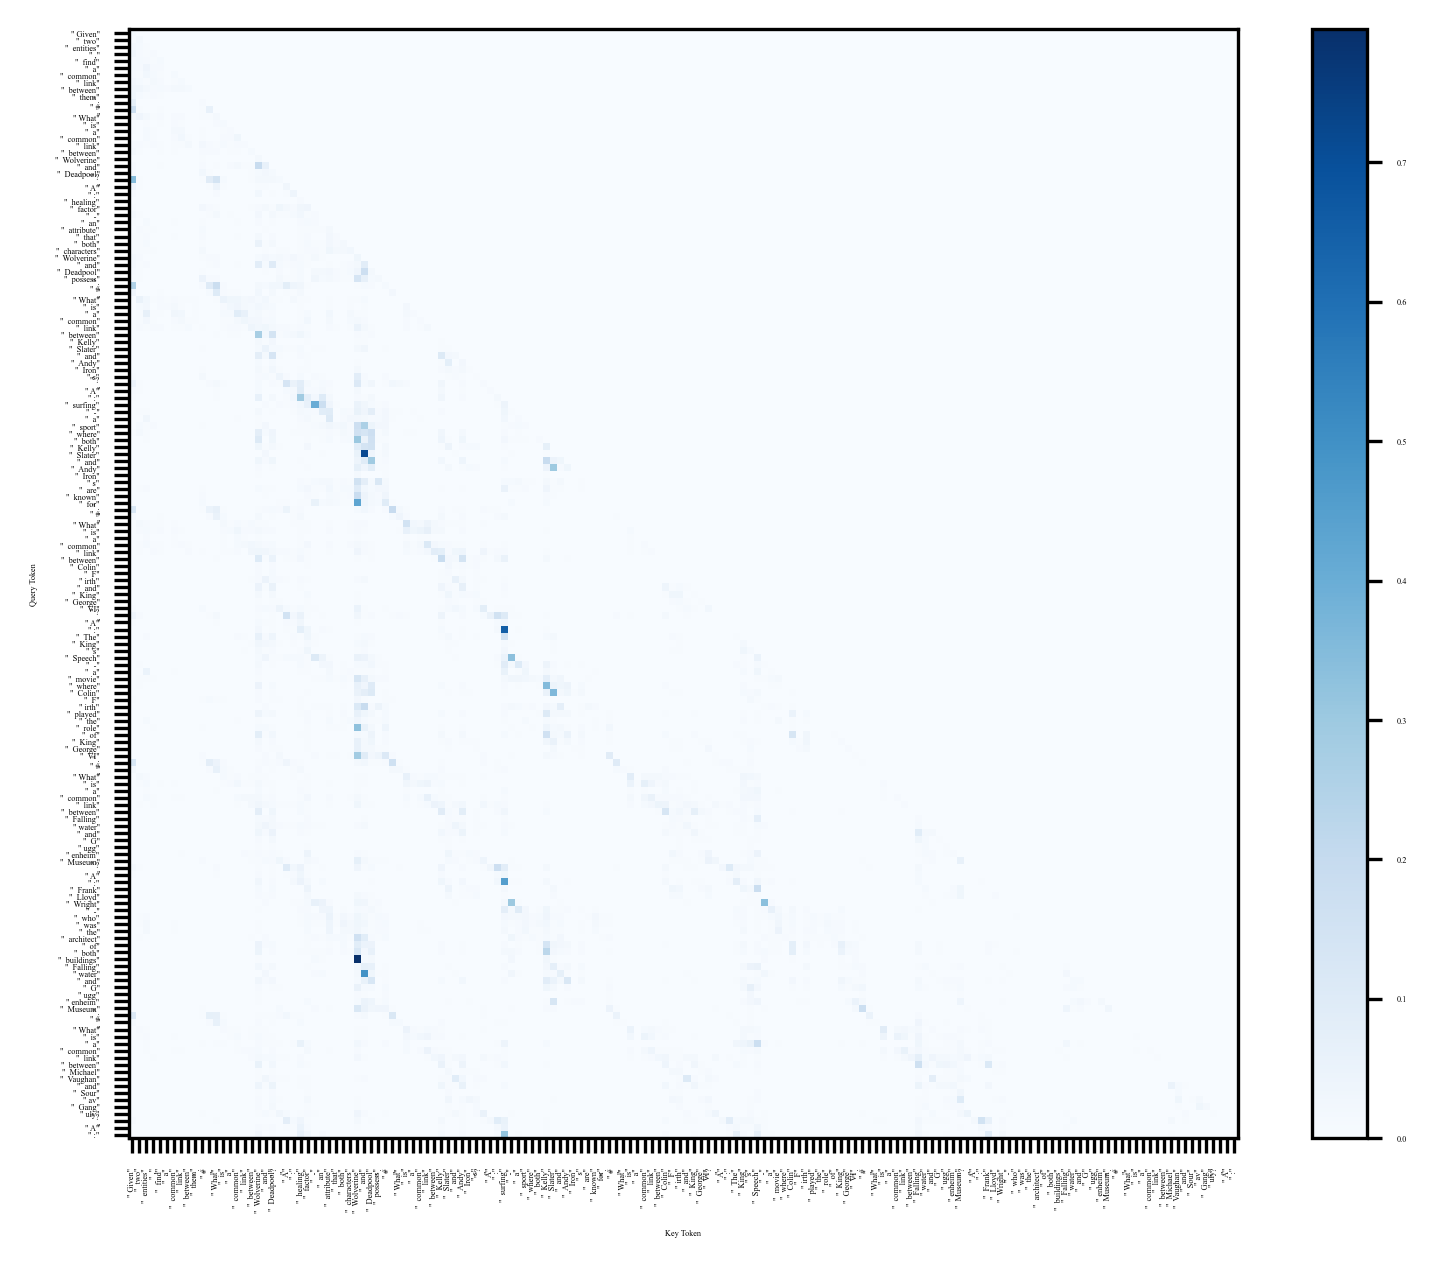

In [109]:
from src.plotting import visualize_attn_matrix

visualize_attn_matrix(
    attn_matrix=cache_attn_matrices[head].squeeze().cpu().detach().numpy(),
    tokens = [mt.tokenizer.decode(t) for t in inputs["input_ids"][0]],
    remove_eos=mt.tokenizer.bos_token,
    savepdf="figures/att_mat.pdf"
)

In [110]:
type(inputs)

transformers.tokenization_utils_base.BatchEncoding

In [114]:
examples = dataset.examples[4:15]

In [117]:
examples

[BridgeSample(bridge='The Social Network', entity_pair=['Jesse Eisenberg', 'Mark Zuckerberg'], description='The Social Network - a movie where Jesse Eisenberg played the role of Mark Zuckerberg.'),
 BridgeSample(bridge='The Queen', entity_pair=['Helen Mirren', 'Queen Elizabeth II'], description='The Queen - a movie where Helen Mirren played the role of Queen Elizabeth II.'),
 BridgeSample(bridge='The Last Emperor', entity_pair=['John Lone', 'Emperor Puyi'], description='The Last Emperor - a movie where John Lone played the role of Emperor Puyi.'),
 BridgeSample(bridge='hockey', entity_pair=['Wayne Gretzky', 'Mario Lemieux'], description='hockey - a sport where both Wayne Gretzky and Mario Lemieux are known for.'),
 BridgeSample(bridge='basketball', entity_pair=['Michael Jordan', 'LeBron James'], description='basketball - a sport where both Michael Jordan and LeBron James are known for.'),
 BridgeSample(bridge='The Doors', entity_pair=['Val Kilmer', 'Jim Morrison'], description='The Doo